In [1]:
%run setup.py

In [2]:
period_guess, a_guess = (15.34119336866559, 44.22149364981446)

Text(0, 0.5, 'RV [km/s]')

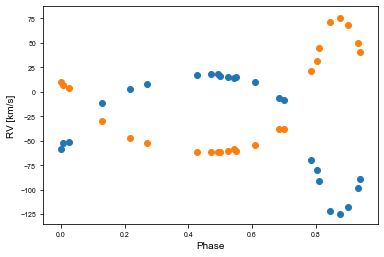

In [5]:
rv_jd_a, rv_rv_a, rv_err_a = np.loadtxt('../../data/kic10080943a_JDrv.txt', delimiter=',', usecols=(0,1,2)).T
rv_jd_a -= 54833 # Phase on TJD

rv_jd_b, rv_rv_b, rv_err_b = np.loadtxt('../../data/kic10080943b_JDrv.txt', delimiter=',', usecols=(0,1,2)).T
rv_jd_b -= 54833

plt.scatter(rv_jd_a % period_guess / period_guess, rv_rv_a)
plt.scatter(rv_jd_b % period_guess / period_guess, rv_rv_b)

plt.xlabel('Phase')
plt.ylabel('RV [km/s]')

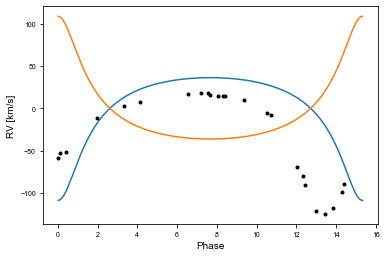

In [7]:
from exoplanet.orbits import get_true_anomaly
import pymc3 as pm
import theano.tensor as tt
from maelstrom.orbit import Orbit

with pm.Model() as model:
    P = pm.Bound(pm.Normal, lower=0, upper=20)("P", mu=period_guess, sd=1,
                                     shape=1, testval=period_guess)
    asini = pm.Normal('asini', mu=np.array([a_guess, -1*a_guess]), sd=5, testval=np.array([a_guess, -1*a_guess]), shape=2)
    
    logs_a = pm.Normal("logs_a", mu=np.log(np.median(rv_err_a)), sd=5.0)
    logs_b = pm.Normal("logs_b", mu=np.log(np.median(rv_err_b)), sd=5.0)
    
    ecc = xo.distributions.UnitUniform("ecc", shape=1, testval=0.5)
    omega = xo.distributions.Angle("omega", shape=1)
    gammav = pm.Uniform('gammav', lower=-50, upper=50, testval=0.)
    phi = xo.distributions.Angle('phi', testval=0.)
    
    orbit_a = Orbit(period=P,
                   lighttime=asini,
                   eccen=ecc,
                   phi = phi,
                   omega=omega)
    
    vrad_a = orbit_a.get_radial_velocity(rv_jd_a)[0] + gammav
    err_a = tt.sqrt(2*rv_err_a**2 + tt.exp(2*logs_a))
    pm.Normal("obs", mu=vrad_a, sd=err_a, observed=rv_rv_a)
 
    vrad_b = orbit_a.get_radial_velocity(rv_jd_b)[1] + gammav
    err_b = tt.sqrt(2*rv_err_b**2 + tt.exp(2*logs_b))
    pm.Normal("obs_b", mu=vrad_b, sd=err_b, observed=rv_rv_b)
    
with model:
    t = np.linspace(rv_jd_a.min()-5, rv_jd_a.max()+5, 1000)
    fine_grid_a = pm.Deterministic('fine_grid_a', orbit_a.get_radial_velocity(t) + gammav)
    
    sort = np.argsort(t % period_guess)
    plt.plot((t % period_guess)[sort], xo.eval_in_model(fine_grid_a)[0][sort])
    plt.plot((t % period_guess)[sort], xo.eval_in_model(fine_grid_a)[1][sort])
    plt.plot(rv_jd_a % period_guess, rv_rv_a,'.k')
    plt.xlabel('Phase')
    plt.ylabel('RV [km/s]')

In [8]:
with model:
    map_soln = xo.optimize(start=model.test_point)
    map_soln = xo.optimize(start=map_soln, vars=[gammav])
    map_soln = xo.optimize(start=map_soln, vars=[phi])
    map_soln = xo.optimize(start=map_soln)

optimizing logp for variables: [phi, gammav, omega, ecc, logs_b, logs_a, asini, P]
334it [00:03, 101.04it/s, logp=-2.165265e+01]
message: Desired error not necessarily achieved due to precision loss.
logp: -1058279.8274430325 -> -21.652648738834795
optimizing logp for variables: [gammav]
3it [00:00, 20.01it/s, logp=-2.165265e+01]  
message: Optimization terminated successfully.
logp: -21.652648738834813 -> -21.652648738834813
optimizing logp for variables: [phi]
3it [00:00, 18.10it/s, logp=-2.165265e+01] 
message: Optimization terminated successfully.
logp: -21.652648738834813 -> -21.652648738834813
optimizing logp for variables: [phi, gammav, omega, ecc, logs_b, logs_a, asini, P]
70it [00:00, 194.56it/s, logp=-2.165332e+01]
message: Desired error not necessarily achieved due to precision loss.
logp: -21.652648738834795 -> -21.652648738834795


In [9]:
map_soln

{'P_interval__': array([1.19038819]),
 'asini': array([ 44.93025166, -43.19861881]),
 'logs_a': array(-0.16542287),
 'logs_b': array(-1.05669113),
 'ecc_logodds__': array([-0.1887441]),
 'omega_angle__': array([[-1.17601042],
        [ 4.31474211]]),
 'gammav_interval__': array(-0.99170885),
 'phi_angle__': array([-2.73138443,  3.54112117]),
 'P': array([15.33620968]),
 'ecc': array([0.45295356]),
 'omega': array([-0.26609297]),
 'gammav': array(-22.94253208),
 'phi': array(-0.65701516),
 'fine_grid_a': array([[ -6.88536721,   4.49359429,  11.8057071 , ..., -43.5501211 ,
         -18.57259442,  -3.04561034],
        [-38.38084634, -49.32125735, -56.35155793, ...,  -3.12916915,
         -27.14405031, -42.07261718]])}

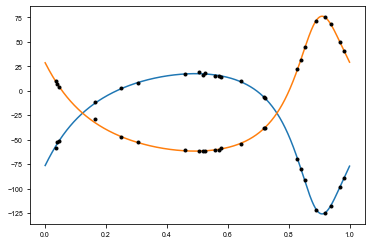

In [12]:
with model:
    fold = t % map_soln['P'] / map_soln['P']
    sort = np.argsort(fold)
    
    plt.plot(fold[sort], map_soln['fine_grid_a'][0][sort])
    plt.plot(rv_jd_a % map_soln['P'] / map_soln['P'], rv_rv_a,'.k')
    
    plt.plot(fold[sort], xo.eval_in_model(fine_grid_a, map_soln)[1][sort])
    plt.plot(rv_jd_b % map_soln['P'] / map_soln['P'], rv_rv_b,'.k')

In [13]:
np.random.seed(42)
with model:
    trace = pm.sample(tune=2000, draws=2000, step=xo.get_dense_nuts_step(target_accept=0.95), start=map_soln)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [phi, gammav, omega, ecc, logs_b, logs_a, asini, P]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:35<00:00, 226.68draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [15]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
asini__0,44.937557,0.173891,0.002630,44.591547,45.267865,4270.402482,0.999776
asini__1,-43.196569,0.092855,0.001431,-43.375847,-43.017683,4162.171395,0.999756
logs_a,-0.096199,0.167014,0.002597,-0.420764,0.231425,4495.182627,1.000221
logs_b,-0.851409,0.226266,0.003889,-1.278367,-0.393115,3597.955462,0.999769
P__0,15.336222,0.000180,0.000004,15.335863,15.336577,2289.449651,1.000189
...,...,...,...,...,...,...,...
fine_grid_a__1_995,75.996845,0.301162,0.004459,75.351903,76.560733,4547.248729,0.999892
fine_grid_a__1_996,36.722823,0.278042,0.004746,36.206985,37.300294,3292.522399,1.000069
fine_grid_a__1_997,-3.090659,0.260676,0.004708,-3.603044,-2.589507,3048.048664,0.999945
fine_grid_a__1_998,-27.104896,0.241681,0.004193,-27.558390,-26.612804,3212.549770,0.999922


In [16]:
model.free_RVs

[P_interval__,
 asini,
 logs_a,
 logs_b,
 ecc_logodds__,
 omega_angle__,
 gammav_interval__,
 phi_angle__]

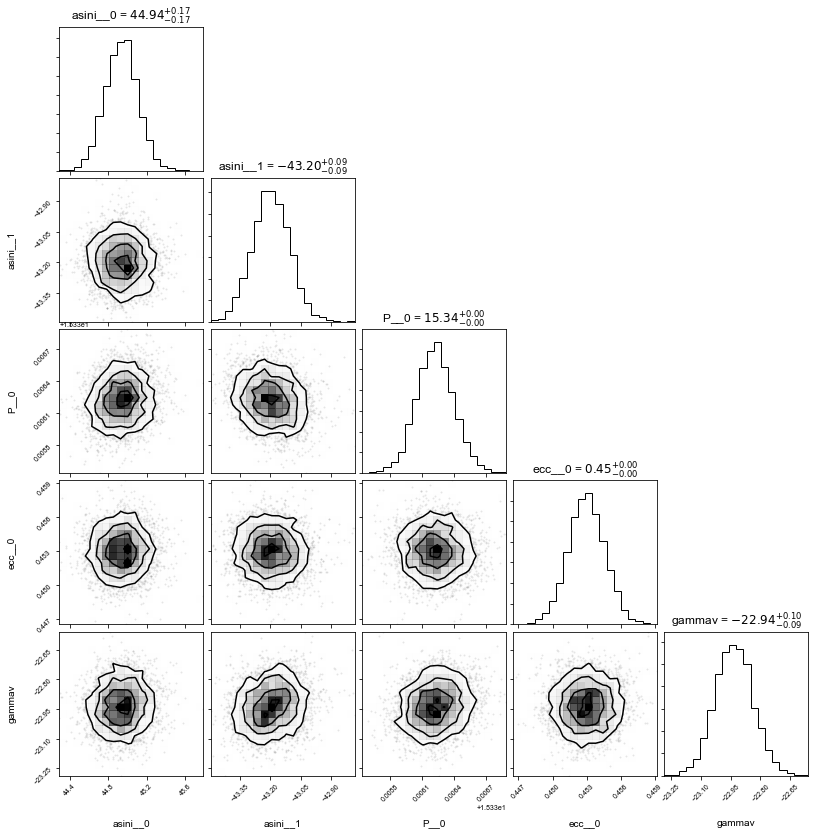

In [18]:
import corner

corner.corner(pm.trace_to_dataframe(trace, varnames=['asini', 'P', 'ecc', 'gammav']), smooth=0.1, show_titles=True);

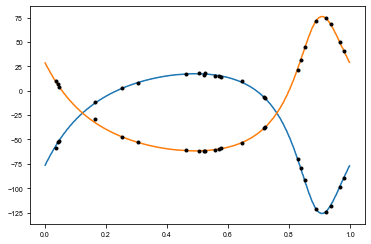

In [31]:
med_rv = np.median(trace['fine_grid_a'], axis=0)
std_rv = np.std(trace['fine_grid_a'], axis=0)
period_val = np.median(trace['P'])

fold = t % samp['P'] / samp['P']
sort = np.argsort(fold)

plt.plot(fold[sort], med_rv[0][sort])
plt.fill_between(fold[sort], (med_rv[0] + std_rv[0])[sort], (med_rv[0] - std_rv[0])[sort])
plt.plot(rv_jd_a % period_val/period_val, rv_rv_a,'.k')

plt.plot(fold[sort], med_rv[1][sort])
plt.fill_between(fold[sort], (med_rv[1] + std_rv[1])[sort], (med_rv[1] - std_rv[1])[sort])
plt.plot(rv_jd_b % period_val/period_val, rv_rv_b,'.k')

In [34]:
pm.save_trace(trace,'KIC 6780873/traces/RV')

'KIC 6780873/traces/RV'

In [35]:
(np.median(trace['phi']) / 2*np.pi) % np.median(trace['P']) / np.median(trace['P'])

0.9326168470106302

In [29]:
np.median(trace['phi']) * np.median(trace['P']) / 2*np.pi

-15.848501893635182

In [27]:
tref % np.median(trace['P']) / np.median(trace['P'])

0.9665968706496305

In [11]:
2*np.pi tref / p = phi

NameError: name 'tref' is not defined

0.8663874825985216

In [24]:
np.median(trace['phi'])

-0.6578848649709785

In [ ]:
2*np.pi (t/p - tref/p)

In [ ]:
2*np.pi t/p - 2*np.pi tref / p

In [45]:
phi = 3
tref = None

In [48]:
phi is not None and tref is not None

False

In [47]:
np.logical_xor(phi, tref)

AttributeError: 'int' object has no attribute 'logical_xor'

In [5]:
x, y, yerr = rv_jd_a, rv_rv_a, rv_err_a

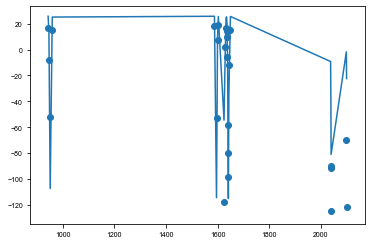

In [17]:
from exoplanet.orbits import get_true_anomaly
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
    P = pm.Bound(pm.Normal, lower=0)("P", mu=period_guess, sd=1,
                                     shape=1, testval=period_guess)

    # Wide log-normal prior for semi-amplitude
    logasini = pm.Bound(pm.Normal, lower=0)("logasini", mu=np.log(a_guess), sd=10.0,
                                        shape=1, testval=np.log(a_guess))
    asini = pm.Deterministic('asini', tt.exp(logasini))
    logs = pm.Normal("logs", mu=np.log(np.median(yerr)), sd=5.0)
    # Eccentricity & argument of periasteron
    ecc = xo.distributions.UnitUniform("ecc", shape=1, testval=0.45)
    omega = xo.distributions.Angle("omega", shape=1)
    gammav = pm.Uniform('gammav', lower=-50, upper=50, testval=-13)
    
#     t0 = pm.Normal('t0', mu=0., sd=10, testval=0.)    
#     sinw = tt.sin(omega)
#     cosw = tt.cos(omega)
#     opsw = 1 + sinw
#     E0 = 2 * tt.arctan2(tt.sqrt(1-ecc)*cosw, tt.sqrt(1+ecc)*opsw)
#     M0 = E0 - ecc * tt.sin(E0)
#     tref = pm.Deterministic("tref", t0 - M0 * P / (2*np.pi))
    
#     # Mean anom
#     M = 2.0 * np.pi * (x - tref) / P
    
    phi = xo.distributions.Angle('phi', testval=0.)
    M = 2. * np.pi * x / P - phi
    # True anom
    f = get_true_anomaly(M, ecc + tt.zeros_like(M))
    vrad = -2.0 * np.pi * ((tt.exp(logasini) / 86400) / P) * (1/tt.sqrt(1.0 - tt.square(ecc))) * (tt.cos(f + omega) + ecc*tt.cos(omega))
    vrad *= 299792.458  # c in km/s
    vrad += gammav # Systemic velocity
    err = tt.sqrt(2*yerr**2 + tt.exp(2*logs))
    pm.Normal("obs", mu=vrad, sd=err, observed=y)
    
    plt.plot(x, xo.eval_in_model(vrad))
    plt.scatter(x, y)
    
    
t = np.linspace(x.min()-5, x.max()+5, 1000)
with model:
#     M2 = 2. * np.pi * (t - tref) / P# - phi
    M2 = 2. * np.pi * t / P - phi
    f2 = get_true_anomaly(M2, ecc + tt.zeros_like(M2))
    vrad2 = -2.0 * np.pi * ((tt.exp(logasini) / 86400) / P) * (1/tt.sqrt(1.0 - tt.square(ecc))) * (tt.cos(f2 + omega) + ecc*tt.cos(omega))
    vrad2 *= 299792.458  # c in km/s|
    vrad2 += gammav # Systemic velocity
    pm.Deterministic("vrad_pred", vrad2)

In [18]:
with model:
    map_soln = xo.optimize(start=model.test_point)
    map_soln = xo.optimize(start=map_soln, vars=[gammav])
    map_soln = xo.optimize(start=map_soln, vars=[phi])
    map_soln = xo.optimize(start=map_soln)

optimizing logp for variables: [phi, gammav, omega, ecc, logs, logasini, P]
299it [00:00, 342.52it/s, logp=3.473640e+00] 
message: Desired error not necessarily achieved due to precision loss.
logp: -402217.4990392485 -> 3.473640218317801
optimizing logp for variables: [gammav]
5it [00:00, 39.37it/s, logp=3.473640e+00]  
message: Optimization terminated successfully.
logp: 3.473640218317801 -> 3.473640218317911
optimizing logp for variables: [phi]
47it [00:00, 193.07it/s, logp=3.473640e+00]
message: Desired error not necessarily achieved due to precision loss.
logp: 3.473640218317911 -> 3.473640218317911
optimizing logp for variables: [phi, gammav, omega, ecc, logs, logasini, P]
67it [00:00, 235.94it/s, logp=7.342263e-01] 
message: Desired error not necessarily achieved due to precision loss.
logp: 3.473640218317911 -> 3.473640218317911


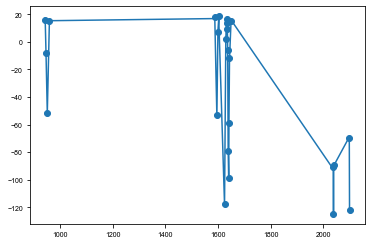

In [19]:
with model:
    plt.scatter(x,y)
    plt.plot(x, xo.eval_in_model(vrad,map_soln))

KeyError: 'tref'

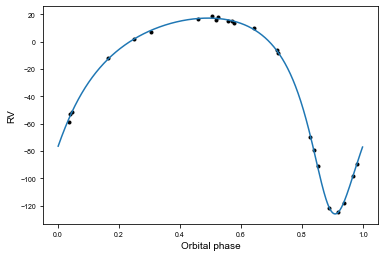

In [20]:
with model:
    plt.plot(x % map_soln['P'] / map_soln['P'],y, '.k')
    t_fold = t % map_soln['P'] / map_soln['P']
    sort = np.argsort(t_fold)
    plt.plot(t_fold[sort], xo.eval_in_model(vrad2,map_soln)[sort])
    
plt.xlabel('Orbital phase')
plt.ylabel('RV')
plt.axvline(map_soln['tref'] % map_soln['P'] / map_soln['P'])

In [33]:
map_soln['phi'] / 2*np.pi# / map_soln['P']

-1.0314318419143564

In [16]:
map_soln['tref'] % map_soln['P'] / map_soln['P']

array([0.89549337])

In [21]:
map_soln

{'P_lowerbound__': array([2.73022116]),
 'logasini_lowerbound__': array([1.33641536]),
 'logs': array(-0.18723771),
 'ecc_logodds__': array([-0.18486027]),
 'omega_angle__': array([[-1.16249444],
        [ 4.31840249]]),
 'gammav_interval__': array(-0.99360165),
 'phi_angle__': array([-2.73002043,  3.54217377]),
 'P': array([15.33627836]),
 'logasini': array([3.80537812]),
 'asini': array([44.94224034]),
 'ecc': array([0.4539161]),
 'omega': array([-0.26296183]),
 'gammav': array(-22.97987279),
 'phi': array(-0.6566299),
 'vrad_pred': array([-6.83835732e+00,  4.49977745e+00,  1.17718256e+01,  1.59657413e+01,
         1.72859362e+01,  1.51941366e+01,  7.93953021e+00, -9.06677615e+00,
        -4.76309859e+01, -1.14475168e+02, -1.07615270e+02, -5.89916987e+01,
        -2.77882985e+01, -8.87156336e+00,  3.18275482e+00,  1.09463302e+01,
         1.55460295e+01,  1.72846720e+01,  1.57423684e+01,  9.39795542e+00,
        -5.75379231e+00, -4.01559747e+01, -1.05955796e+02, -1.14385489e+02,
    